## American Sign Language

Given dataset with signs of numbers 1-10 we are going to create CNN model to recognize those digits from given images.

In [97]:
from preparing_data import *
import matplotlib.pyplot as plt
import os
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import numpy as np

%matplotlib inline

ZIP_PATH = os.path.join(os.getcwd(), 'data/numbers/archive.zip')
UNZIP_PATH = os.path.join(os.getcwd(), 'data/numbers/')

### Preparing Data

We are splitting data for train/validation/test directories so we can use TensorFlow loading data from directories API

In [2]:
unzip_data(ZIP_PATH, UNZIP_PATH, True)

In [2]:
TRAINING_PATH = os.path.join(UNZIP_PATH, 'Train_Nums/')
TEST_PATH = os.path.join(UNZIP_PATH, 'Test_Nums/')

os.rename(TRAINING_PATH, os.path.join(UNZIP_PATH, 'Training/'))
os.rename(TEST_PATH, os.path.join(UNZIP_PATH, 'Test/'))

TEST_PATH = os.path.join(UNZIP_PATH, 'Test/')
TRAINING_PATH = os.path.join(UNZIP_PATH, 'Training/')
VALIDATION_PATH = os.path.join(UNZIP_PATH, 'Validation/')

assert os.path.isdir(TRAINING_PATH)

assert os.path.isdir(TEST_PATH)

Splitting given test set into validation/test set with 70%-validation, 30%-test split.

In [99]:
split_test_val(TEST_PATH, VALIDATION_PATH, 0.7)

Printing each set length

In [3]:
tr = data_counter(TRAINING_PATH, 'Training')
te = data_counter(TEST_PATH, 'Test')
vl = data_counter(VALIDATION_PATH, 'Validation')

Number of files in Training is 9900
Number of files in Test is 330
Number of files in Validation is 770


### Load data

Using image_dataset_from_directory we are loading data from specified directories for train, validation and test sets.

In [51]:
batch_s = 32
image_s = (256, 256)

training_data = tf.keras.utils.image_dataset_from_directory(directory=TRAINING_PATH,
                                                labels='inferred',
                                                label_mode='int',
                                                color_mode='rgb',
                                                shuffle=True,
                                                batch_size=batch_s,
                                                image_size=image_s)

validation_data = tf.keras.utils.image_dataset_from_directory(directory=VALIDATION_PATH,
                                                labels='inferred',
                                                label_mode='int',
                                                color_mode='rgb',
                                                shuffle=False,
                                                batch_size=batch_s,
                                                image_size=image_s)

test_data = tf.keras.utils.image_dataset_from_directory(directory=TEST_PATH,
                                                labels='inferred',
                                                label_mode='int',
                                                color_mode='rgb',
                                                shuffle=False,
                                                batch_size=1,
                                                image_size=image_s)

                                        
assert training_data.class_names == validation_data.class_names == test_data.class_names

Found 9900 files belonging to 11 classes.
Found 770 files belonging to 11 classes.
Found 330 files belonging to 11 classes.


Printing calsses names from dataset.

In [52]:
names = training_data.class_names
print(f"Class names are: {names}")

Class names are: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'Blank']


#### Printing random examples from training directory

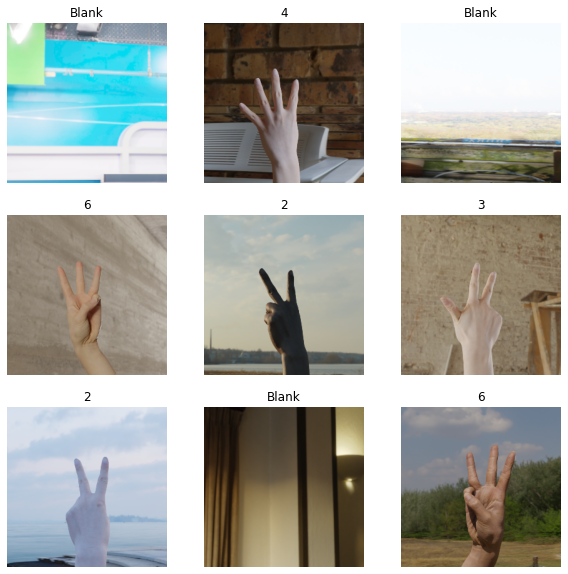

In [53]:
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(names[labels[i]])
    plt.axis("off")


## Data Augumentation to prevent overfitting

Using TensorFlow Sequential API, we are creating data augumentation model for preprocessing data.
Then we are plotting some augumentations on a single training example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


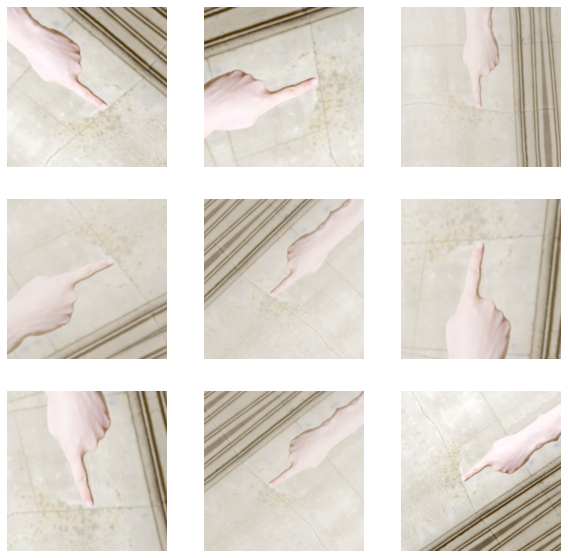

In [8]:
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(factor=(0.1, 0.9)),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.4))
])

plt.figure(figsize=(10, 10))
for images, _ in training_data.take(1):
    for i in range(9):
        augumented = data_augumentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augumented[0].numpy().astype('float32'))
        plt.axis('off')

# augumented_ds = training_data.map(lambda x, y: (data_augumentation(x), y))
# augumented_ds

In [91]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [98]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print(f'\nTraining accuracy greater than or equal to 99% so stop training on epoch {epoch+1}.')
            self.model.stop_training = True

In [11]:
callback = MyCallback()
!rm -rf ./logs/resnet_numbers
!mkdir ./logs/resnet_numbers

!rm -rf ./saved_models/asl*
!mkdir ./saved_models/asl_inception_resnet

checkpoint_path = './saved_models/asl_inception_resnet/cp.cpkt'
os.path.dirname(checkpoint_path)

tf_board_callback = TensorBoard(log_dir='./logs/resnet_numbers/', write_graph=True, update_freq='epoch')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

input = Input(shape=(256, 256, 3))
x = data_augumentation(input)
x = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights=None, input_shape=(256, 256, 3))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(11, activation='softmax')(x)

inception_resnet_model = Model(input, x)

inception_resnet_model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy')
history_inception_resnet_no_weights = inception_resnet_model.fit(training_data,
                                                                epochs=50,
                                                                validation_data=validation_data,
                                                                callbacks=[callback, tf_board_callback, checkpoint_callback])

/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Epoch 1/50
310/310 [==============================] - ETA: 0s - loss: 4.8402 - accuracy: 0.1025
Epoch 1: val_accuracy improved from -inf to 0.12468, saving model to ./saved_models/asl_inception_resnet/cp.cpkt
310/310 [==============================] - 188s 555ms/step - loss: 4.8402 - accuracy: 0.1025 - val_loss: 2.3761 - val_accuracy: 0.1247
Epoch 2/50
310/310 [==============================] - ETA: 0s - loss: 2.2694 - accuracy: 0.1691
Epoch 2: val_accuracy improved from 0.12468 to 0.16234, saving model to ./saved_models/a

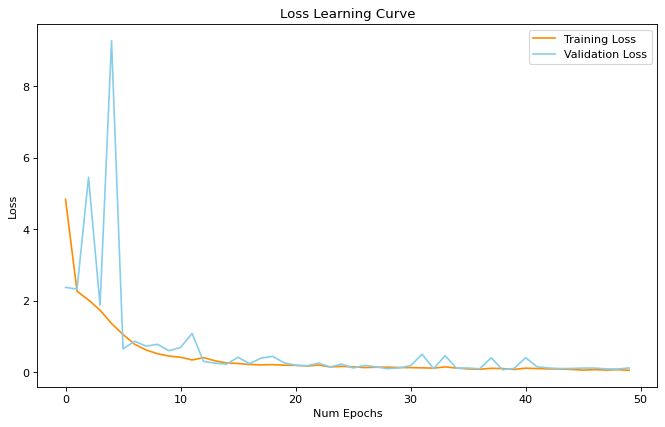

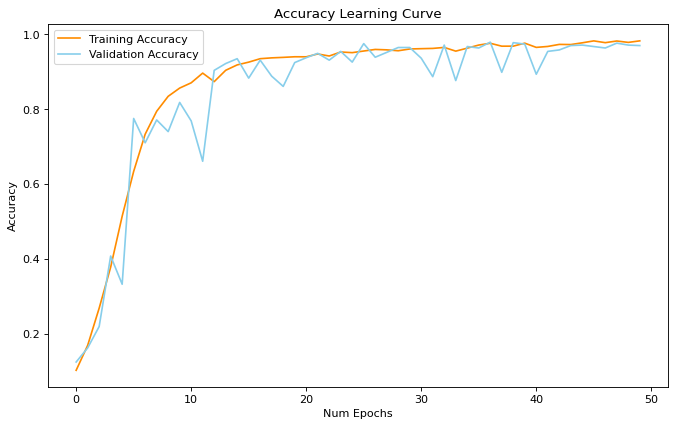

In [12]:
plot_learning(history_inception_resnet_no_weights, 'loss', 'val_loss', xtitle='Num Epochs', ytitle='Loss', plot_title='Loss Learning Curve', label_1='Training Loss', label_2='Validation Loss')
plot_learning(history_inception_resnet_no_weights, 'accuracy', 'val_accuracy', 'Num Epochs', 'Accuracy', plot_title='Accuracy Learning Curve', label_1='Training Accuracy', label_2='Validation Accuracy')


As we can see after several epochs model tend to normalize and slowly flatten, validation accuracy is not much smaler or lower than training accuracy so we are not overfitting the data. We could try some hyperparameters tunning to maybe maximize model's preformance but 98% training and 97% validation accuracy is satysfying.

### Create new model for loading weights

Model has to be the same in order to load weights from previous session.

In [16]:
checkpoint_path = './saved_models/asl_inception_resnet/cp.cpkt'

inpt = Input(shape=(256, 256, 3))
y = data_augumentation(inpt)
y = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights=None, input_shape=(256, 256, 3))(y)
y = Flatten()(y)
y = Dense(1024, activation='relu')(y)
y = Dropout(0.4)(y)
y = Dense(11, activation='softmax')(y)

resnet_loaded = Model(inpt, y)

resnet_loaded.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy')

### Load precomputed weights from previous session

In [17]:
resnet_loaded.load_weights(checkpoint_path)

In [18]:
resnet_loaded.evaluate(test_data)

330/330 [==============================] - 15s 27ms/step - loss: 0.1322 - accuracy: 0.9667


[0.13222093880176544, 0.9666666388511658]

Our model scores 96.6% on training set which is pretty simmilar to validation.

## Classification report

In [92]:
from sklearn.metrics import classification_report

In [96]:
test_list = list(test_data.as_numpy_iterator())

y_true = [names[label[0]] for image, label in test_list]

y_pred = [names[np.argmax(resnet_loaded.predict(image, verbose=0))] for image, label in test_list]

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        30
          10       0.91      1.00      0.95        30
           2       0.94      1.00      0.97        30
           3       1.00      0.97      0.98        30
           4       0.97      1.00      0.98        30
           5       0.97      0.97      0.97        30
           6       1.00      0.97      0.98        30
           7       1.00      0.93      0.97        30
           8       0.97      0.97      0.97        30
           9       0.97      0.97      0.97        30
       Blank       0.94      0.97      0.95        30

    accuracy                           0.97       330
   macro avg       0.97      0.97      0.97       330
weighted avg       0.97      0.97      0.97       330



## Results

Using model predictions and matplotlib we are showing images along with predicted and actuall class.

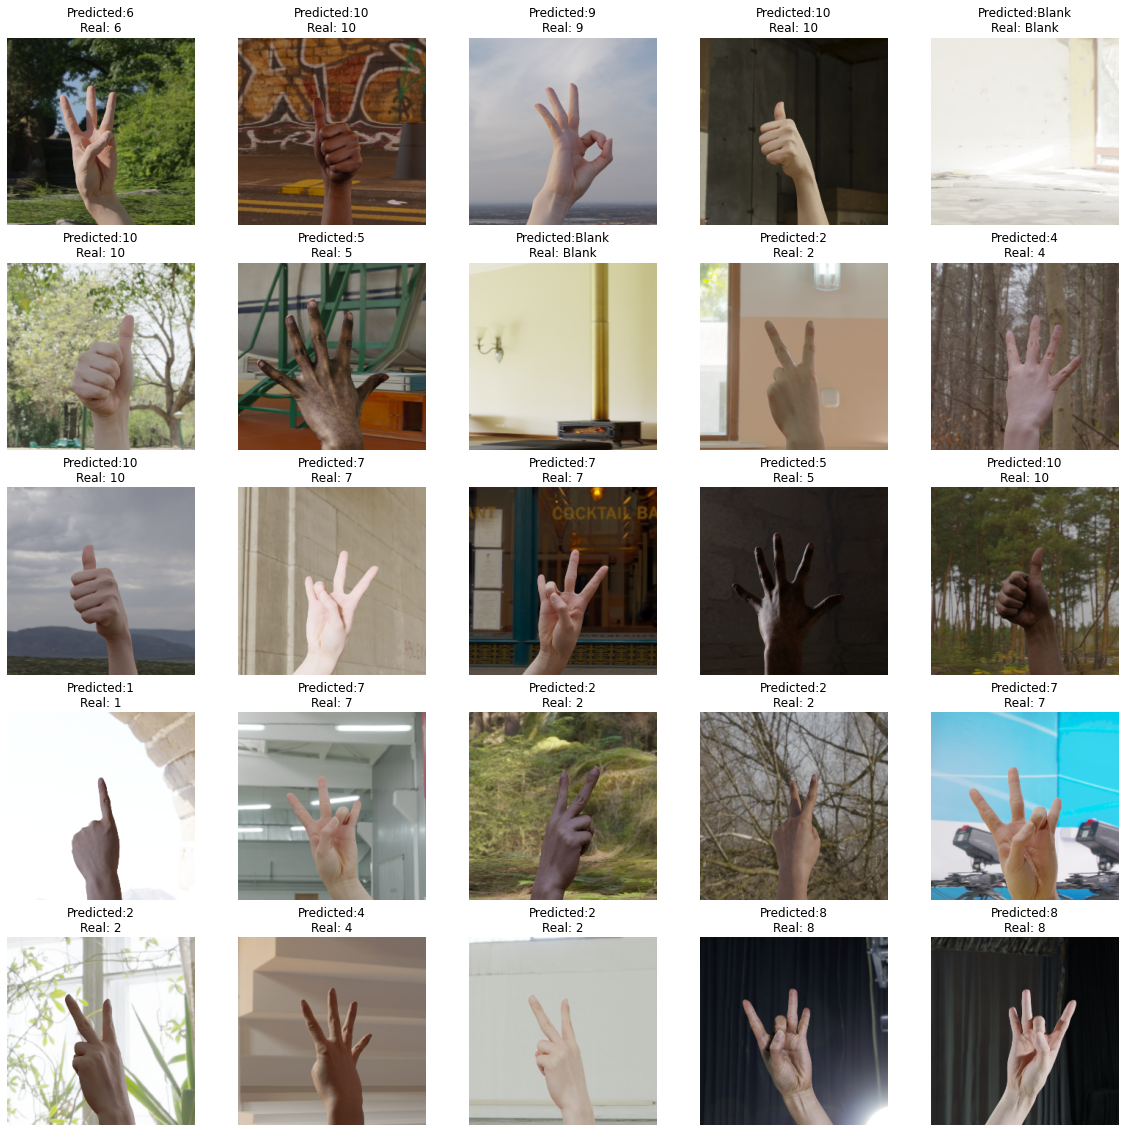

In [89]:
plt.figure(figsize=(20, 20))

i = 0
for image, label in random.sample(test_list, 25):
    prediction = np.argmax(resnet_loaded.predict(image, verbose=0))
    title = f"Predicted:{names[prediction]}\nReal: {str(names[label[0]])}"
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image[0].astype('uint8'))
    plt.title(title)
    plt.axis('off')
    i+=1

### Saving model

We are saving model for further use with tf.Model().save(), we can use it for example in another dataset with ASL letters. It's going to be great start for this problem since photos are in simmilar format.

In [21]:
#Remove directory if exists
!rm -rf ./saved_models/inception_resnet 

#Create empty directory for files
!mkdir ./saved_models/inception_resnet

resnet_loaded.save('./saved_models/inception_resnet/')

/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/barti/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
